## Data Cleaning and Preprocessing

In [ ]:
import pandas as pd
df=pd.read_csv("/content/Cleaned Data - Cleaned Data.csv")
df

,Age_group,Sex,Topic,Data_source,Health_condition-Data_source,Period,Year,Denominator,Denominator_is,Number_with_outcome,...,Race_ethnicity,Rate_title,Trend_title,Filter_1000_or_more,Sort_1000_or_more,Primary_Neighborhood,Cause of death rank,Death_tooltip,Latest_data,Unique_row_id
0,0,0,5,0,32,43,22,-0.198251,18,-0.704734,...,0,1099,210,3,-0.912877,1,0,1,0,-1.283738
1,0,0,5,0,32,47,23,-0.227846,18,-0.510436,...,0,1100,210,3,-0.912877,1,0,1,0,-0.354644
2,0,0,5,0,32,50,24,-0.261700,18,-0.478053,...,0,1102,210,3,-0.912877,1,0,1,0,-0.253600
3,0,0,5,0,32,52,25,-0.287534,18,-0.715529,...,0,1103,210,3,-0.912877,1,0,1,0,-1.358848
4,0,0,5,0,32,27,22,-0.314219,18,-0.747912,...,0,1097,210,3,-0.912877,1,0,1,0,-1.621209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43737,43,2,5,11,384,39,22,2.085356,12,0.936005,...,0,6603,1228,1,1.418047,1,0,1,0,1.274209
43738,43,2,5,11,384,48,22,-0.606200,12,-0.715529,...,4,6607,1228,3,-0.912877,1,0,1,0,-1.295162
43739,43,2,5,11,384,48,22,-0.563687,12,-0.553614,...,0,6607,1228,3,-0.912877,1,0,1,0,-0.472693
43740,43,2,5,11,384,48,22,0.283652,12,-0.348521,...,0,6607,1228,4,0.252585,1,0,1,0,0.099497


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
missing_values_after_cleaning = df.isnull().sum()
print("Missing Values:\n", missing_values_after_cleaning)

Missing Values:
 Age_group                       0
Sex                             0
Topic                           0
Data_source                     0
Health_condition-Data_source    0
Period                          0
Year                            0
Denominator                     0
Denominator_is                  0
Number_with_outcome             0
Numerator_is                    0
Rate_95CI                       0
Rate_SF_pop                     0
CI_low                          0
CI_high                         0
Rate_is                         0
Insurance                       0
Zip_code                        0
Race_ethnicity                  0
Rate_title                      0
Trend_title                     0
Filter_1000_or_more             0
Sort_1000_or_more               0
Primary_Neighborhood            0
Cause of death rank             0
Death_tooltip                   0
Latest_data                     0
Unique_row_id                   0
dtype: int64


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'Year' in numerical_cols:
    numerical_cols.remove('Year')

# Clustering


Because the dataset is originally unlabeled, we first apply clustering to group the records into three risk-based clusters: **Low Risk**, **Medium Risk**, and **High Risk**. These cluster assignments are then used as pseudo-labels to train and evaluate  classification models.


## K-Means Clustering

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=25)
df['kmeans_cluster'] = kmeans.fit_predict(df[numerical_cols])

# Assign risk levels based on cluster centroid of Rate_SF_pop
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=numerical_cols)
centroids['cluster'] = centroids.index
centroids_sorted = centroids.sort_values(by='Rate_SF_pop')

risk_map = {centroids_sorted.iloc[0]['cluster']: 'Low Risk',
            centroids_sorted.iloc[1]['cluster']: 'Medium Risk',
            centroids_sorted.iloc[2]['cluster']: 'High Risk'}

In [ ]:
df['kmeans_cluster'].value_counts()

,count
kmeans_cluster,
0,16720
1,14156
2,12866


## GMM Clustering

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import pandas as pd

gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(df)

df['gmm_cluster'] = -1
df.loc[df.index, 'gmm_cluster'] = gmm_labels

cluster_means = df.groupby('gmm_cluster')['Rate_SF_pop'].mean().sort_values()

risk_map_gmm = {
    cluster_means.index[0]: 'Low Risk',
    cluster_means.index[1]: 'Medium Risk',
    cluster_means.index[2]: 'High Risk'
}

In [ ]:
df['gmm_cluster'].value_counts()

,count
gmm_cluster,
2,16718
0,14149
1,12875


## Clustering Evaluation

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

kmeans_labels = df.loc[df.index, 'kmeans_cluster']

gmm_labels = df.loc[df.index, 'gmm_cluster']

def evaluate_clustering(X, labels, model_name):
    s = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    print(f" {model_name} Evaluation:")
    print(f"  Silhouette Score       : {s:.4f}")
    print(f"  Davies–Bouldin Index   : {db:.4f}")
    print(f"  Calinski–Harabasz Score: {ch:.4f}\n")
    return {'silhouette': s, 'davies_bouldin': db, 'calinski': ch}

kmeans_scores = evaluate_clustering(df, kmeans_labels, "K-Means")
gmm_scores = evaluate_clustering(df, gmm_labels, "GMM")


 K-Means Evaluation:
  Silhouette Score       : 0.4880
  Davies–Bouldin Index   : 0.6924
  Calinski–Harabasz Score: 102783.6981

 GMM Evaluation:
  Silhouette Score       : 0.4875
  Davies–Bouldin Index   : 0.6936
  Calinski–Harabasz Score: 102165.0422



The K-Means model shows a Silhouette Score of 0.4880, which is slightly higher than GMM’s score of 0.4875, indicating marginally better cluster separation and cohesion. In addition, K-Means achieves a lower Davies–Bouldin Index (0.6924) compared to GMM (0.6936), meaning its clusters are slightly more compact and better separated. The Calinski–Harabasz Score is also higher for K-Means (102,783 vs. 102,165), further suggesting that K-Means produces more distinct and well-defined clusters.

According to the scores above, it can be suggested that the K-Means algorithm is performing better overall. Hence, we have considered K-Means labels as the most reliable labels for our previously unlabelled dataset.

In [ ]:
df['Label'] = df['kmeans_cluster'].map(risk_map)

In [ ]:
df=df.drop(["kmeans_cluster", "gmm_cluster"], axis=1)

In [ ]:
df

,Age_group,Sex,Topic,Data_source,Health_condition-Data_source,Period,Year,Denominator,Denominator_is,Number_with_outcome,...,Rate_title,Trend_title,Filter_1000_or_more,Sort_1000_or_more,Primary_Neighborhood,Cause of death rank,Death_tooltip,Latest_data,Unique_row_id,Label
0,0,0,5,0,32,43,22,-0.198251,18,-0.704734,...,1099,210,3,-0.912877,1,0,1,0,-1.283738,Low Risk
1,0,0,5,0,32,47,23,-0.227846,18,-0.510436,...,1100,210,3,-0.912877,1,0,1,0,-0.354644,Low Risk
2,0,0,5,0,32,50,24,-0.261700,18,-0.478053,...,1102,210,3,-0.912877,1,0,1,0,-0.253600,Low Risk
3,0,0,5,0,32,52,25,-0.287534,18,-0.715529,...,1103,210,3,-0.912877,1,0,1,0,-1.358848,Low Risk
4,0,0,5,0,32,27,22,-0.314219,18,-0.747912,...,1097,210,3,-0.912877,1,0,1,0,-1.621209,Low Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43737,43,2,5,11,384,39,22,2.085356,12,0.936005,...,6603,1228,1,1.418047,1,0,1,0,1.274209,Low Risk
43738,43,2,5,11,384,48,22,-0.606200,12,-0.715529,...,6607,1228,3,-0.912877,1,0,1,0,-1.295162,Low Risk
43739,43,2,5,11,384,48,22,-0.563687,12,-0.553614,...,6607,1228,3,-0.912877,1,0,1,0,-0.472693,Low Risk
43740,43,2,5,11,384,48,22,0.283652,12,-0.348521,...,6607,1228,4,0.252585,1,0,1,0,0.099497,Low Risk


In [ ]:
df.to_csv('/content/drive/MyDrive/labelled data.csv', index=False)

# Classification

We are performing 7 classification models to group each child (record) into three labels: Low Risk (0), Medium Risk (1) and High Risk (2). The models used are the following:

1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Support Vector Machine
5. K-Nearest Neighbor
6. XGBoost
7. MLP

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/labelled data.csv")


Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy : 0.9758
Test Accuracy  : 0.9742

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2832
           1       0.96      0.97      0.97      3344
           2       0.97      0.97      0.97      2573

    accuracy                           0.97      8749
   macro avg       0.98      0.97      0.97      8749
weighted avg       0.97      0.97      0.97      8749



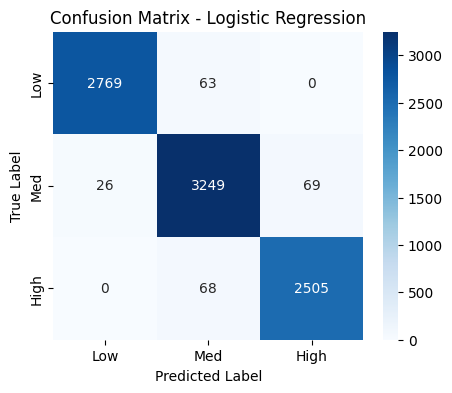


Decision Tree
Train Accuracy : 1.0000
Test Accuracy  : 0.9993

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      1.00      1.00      3344
           2       1.00      1.00      1.00      2573

    accuracy                           1.00      8749
   macro avg       1.00      1.00      1.00      8749
weighted avg       1.00      1.00      1.00      8749



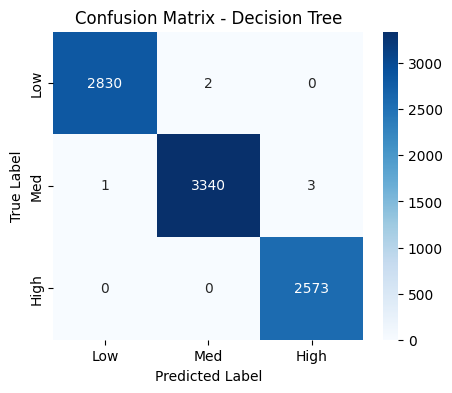


Random Forest
Train Accuracy : 1.0000
Test Accuracy  : 0.9997

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      1.00      1.00      3344
           2       1.00      1.00      1.00      2573

    accuracy                           1.00      8749
   macro avg       1.00      1.00      1.00      8749
weighted avg       1.00      1.00      1.00      8749



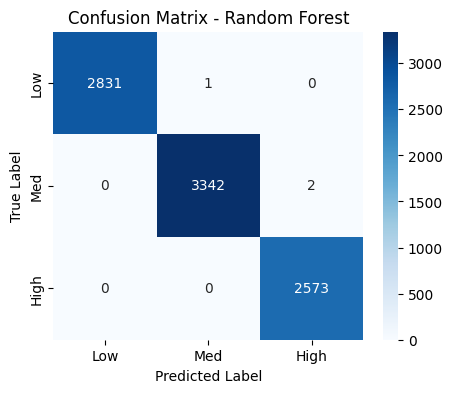


Support Vector Machine
Train Accuracy : 0.9974
Test Accuracy  : 0.9979

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       0.99      1.00      1.00      3344
           2       1.00      0.99      1.00      2573

    accuracy                           1.00      8749
   macro avg       1.00      1.00      1.00      8749
weighted avg       1.00      1.00      1.00      8749



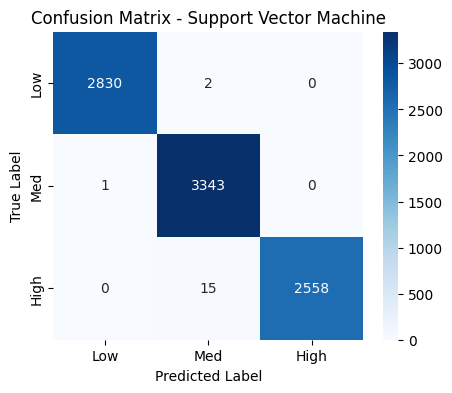


K-Nearest Neighbors
Train Accuracy : 0.9998
Test Accuracy  : 0.9994

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      1.00      1.00      3344
           2       1.00      1.00      1.00      2573

    accuracy                           1.00      8749
   macro avg       1.00      1.00      1.00      8749
weighted avg       1.00      1.00      1.00      8749



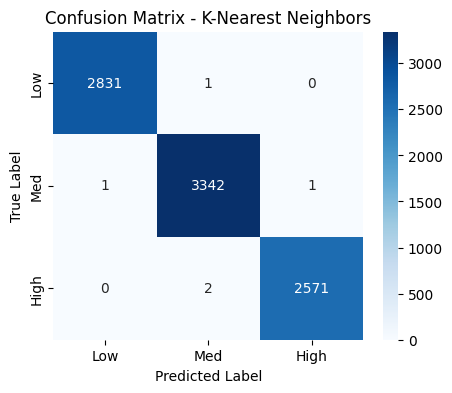


XGBoost
Train Accuracy : 1.0000
Test Accuracy  : 0.9991

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      1.00      1.00      3344
           2       1.00      1.00      1.00      2573

    accuracy                           1.00      8749
   macro avg       1.00      1.00      1.00      8749
weighted avg       1.00      1.00      1.00      8749



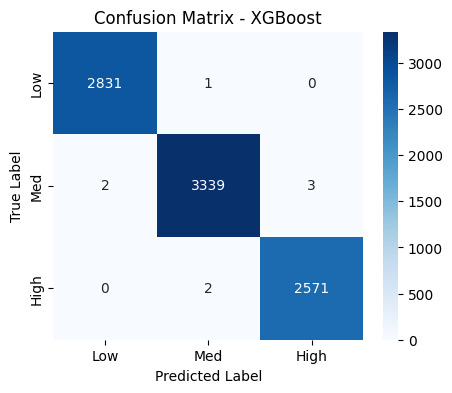


MLP Neural Network
Train Accuracy : 0.9076
Test Accuracy  : 0.9118

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2832
           1       0.81      1.00      0.90      3344
           2       0.99      0.79      0.88      2573

    accuracy                           0.91      8749
   macro avg       0.94      0.90      0.91      8749
weighted avg       0.93      0.91      0.91      8749



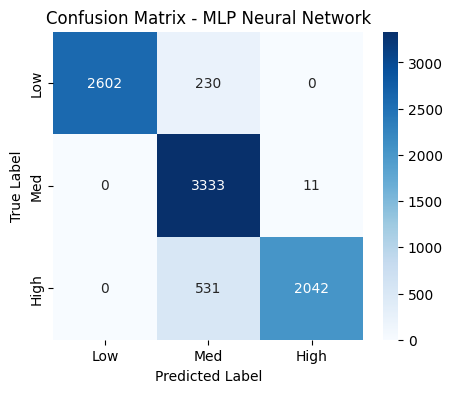

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns


X = df.drop(columns=['Label'])
y = df['Label']

label_mapping = {
    "Low Risk": 0,
    "Medium Risk": 1,
    "High Risk": 2
}
y = y.map(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=14),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=14),
    "Support Vector Machine": SVC(kernel='rbf', probability=True, random_state=14),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3),
    "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss', random_state=14),
    "MLP Neural Network": MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=300,
        random_state=14
    )
}


results = {}

for name, model in models.items():
    print(f"\n{name}")
    print("=" * 60)

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train_acc  = accuracy_score(y_train, y_train_pred)
    test_acc   = accuracy_score(y_test, y_test_pred)

    train_prec = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_prec  = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)

    train_rec  = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_rec   = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)

    train_f1   = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_f1    = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    results[name] = {
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Train Precision": train_prec,
        "Test Precision": test_prec,
        "Train Recall": train_rec,
        "Test Recall": test_rec,
        "Train F1": train_f1,
        "Test F1": test_f1
    }

    print(f"Train Accuracy : {train_acc:.4f}")
    print(f"Test Accuracy  : {test_acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Low", "Med", "High"],
                yticklabels=["Low", "Med", "High"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("=" * 60)


In [ ]:
classification_results_df = pd.DataFrame(results).T
classification_results_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1
Logistic Regression,0.975795,0.974168,0.975858,0.974292,0.975795,0.974168,0.975817,0.974206
Decision Tree,1.000000,0.999314,1.000000,0.999314,1.000000,0.999314,1.000000,0.999314
Random Forest,1.000000,0.999657,1.000000,0.999657,1.000000,0.999657,1.000000,0.999657
Support Vector Machine,0.997428,0.997943,0.997443,0.997952,0.997428,0.997943,0.997428,0.997943
K-Nearest Neighbors,0.999800,0.999429,0.999800,0.999429,0.999800,0.999429,0.999800,0.999429
XGBoost,1.000000,0.999086,1.000000,0.999086,1.000000,0.999086,1.000000,0.999086
MLP Neural Network,0.907639,0.911761,0.924707,0.927377,0.907639,0.911761,0.907946,0.912172


**Best Performing Model**

Among all the models tested, Random Forest achieved the strongest overall performance, with near-perfect accuracy, precision, recall, and F1 scores on both training and test sets. Decision Tree and XGBoost also performed remarkably well, but Random Forest stands out due to its stability and consistent generalization. Overall, it is the most reliable and best-performing model in this experiment.

**Least Perfoming models**

The MLP Neural Network performed significantly worse compared to all other models, achieving only around 91% accuracy on both train and test sets. This is substantially lower than the near-perfect scores of the tree-based, linear, and distance-based models.

**Overfitting/Underfitting Behaviour**

Tree-based models such as Decision Tree, Random Forest, and XGBoost show signs of mild overfitting, as they achieve perfect or near-perfect training accuracy with slightly lower—but still extremely high—test performance. Logistic Regression, SVM, and KNN demonstrate good balance, with very small train–test gaps and strong generalization. The MLP Neural Network is the only model showing underfitting, with both training and test performance remaining noticeably lower than other models. This indicates that it failed to fully capture the complexity of the dataset.

### Hyperparameter Tuning

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import joblib   # for saving the model-specific datasets

X = df.drop(columns=['Label'])
y = df['Label']

label_mapping = {
    "Low Risk": 0,
    "Medium Risk": 1,
    "High Risk": 2
}
y = y.map(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=14),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=14),
    "Support Vector Machine": SVC(kernel='rbf', probability=True, random_state=14),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3),
    "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss', random_state=14),
    "MLP Neural Network": MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=300,
        random_state=14
    )
}

In [ ]:
param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "liblinear"]
    },

    "Decision Tree": {
        "clf__max_depth": [3, 5, 10, 20, None],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__max_features": ["sqrt", "log2", None],
        "clf__max_leaf_nodes": [None, 10, 20, 50]
    },

    "Random Forest": {
        "clf__n_estimators": [100, 200, 300],
        "clf__max_depth": [5, 10, 20, None],
        "clf__min_samples_leaf": [1, 2, 4],
    },

    "Support Vector Machine": {
        "clf__C": [0.1, 1, 10],
    },

    "K-Nearest Neighbors": {
        "clf__n_neighbors": [3, 5, 7, 11],
        "clf__weights": ["uniform", "distance"],
    },

    "XGBoost": {
        "clf__n_estimators": [200, 300, 500],
        "clf__max_depth": [3, 5, 7],
    },

    "MLP Neural Network": {
        "clf__hidden_layer_sizes": [(50,), (100,), (100, 50)],
        "clf__activation": ["relu", "tanh"]
    }
}



Logistic Regression
Saved processed dataset for Logistic Regression → logistic_regression_df.csv

Best Hyperparameters:
{'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Train Accuracy : 0.9979
Test Accuracy  : 0.9983

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      1.00      1.00      3344
           2       1.00      1.00      1.00      2573

    accuracy                           1.00      8749
   macro avg       1.00      1.00      1.00      8749
weighted avg       1.00      1.00      1.00      8749



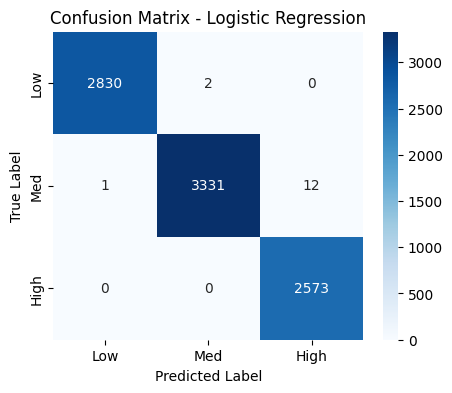


Decision Tree
Saved processed dataset for Decision Tree → decision_tree_df.csv

Best Hyperparameters:
{'clf__max_depth': 10, 'clf__max_features': None, 'clf__max_leaf_nodes': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}

Train Accuracy : 1.0000
Test Accuracy  : 0.9993

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      1.00      1.00      3344
           2       1.00      1.00      1.00      2573

    accuracy                           1.00      8749
   macro avg       1.00      1.00      1.00      8749
weighted avg       1.00      1.00      1.00      8749



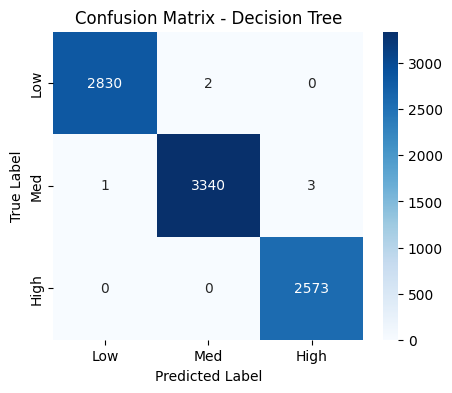


Random Forest
Saved processed dataset for Random Forest → random_forest_df.csv

Best Hyperparameters:
{'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 300}

Train Accuracy : 1.0000
Test Accuracy  : 0.9997

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      1.00      1.00      3344
           2       1.00      1.00      1.00      2573

    accuracy                           1.00      8749
   macro avg       1.00      1.00      1.00      8749
weighted avg       1.00      1.00      1.00      8749



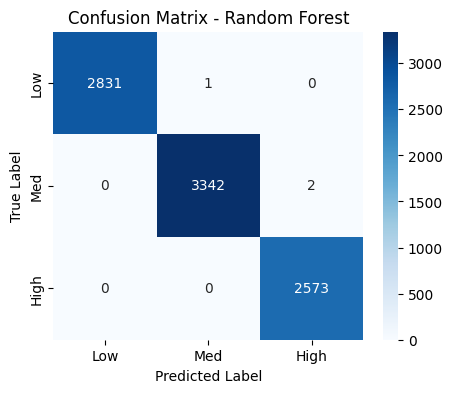


Support Vector Machine
Saved processed dataset for Support Vector Machine → support_vector_machine_df.csv

Best Hyperparameters:
{'clf__C': 10}

Train Accuracy : 0.9976
Test Accuracy  : 0.9922

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2832
           1       0.99      0.99      0.99      3344
           2       0.99      1.00      0.99      2573

    accuracy                           0.99      8749
   macro avg       0.99      0.99      0.99      8749
weighted avg       0.99      0.99      0.99      8749



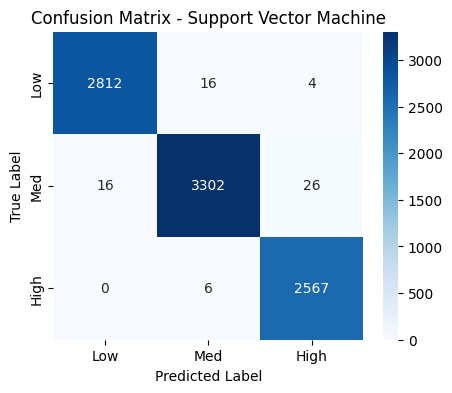


K-Nearest Neighbors
Saved processed dataset for K-Nearest Neighbors → k-nearest_neighbors_df.csv

Best Hyperparameters:
{'clf__n_neighbors': 11, 'clf__weights': 'distance'}

Train Accuracy : 1.0000
Test Accuracy  : 0.9294

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2832
           1       0.91      0.90      0.91      3344
           2       0.94      0.93      0.93      2573

    accuracy                           0.93      8749
   macro avg       0.93      0.93      0.93      8749
weighted avg       0.93      0.93      0.93      8749



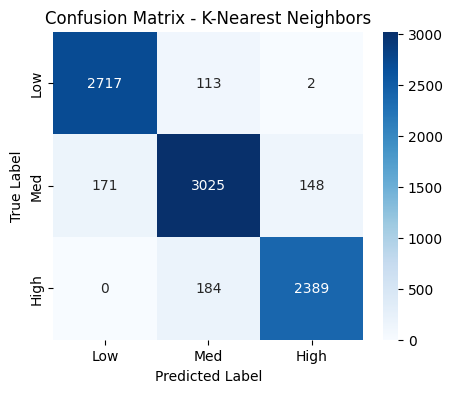


XGBoost
Saved processed dataset for XGBoost → xgboost_df.csv

Best Hyperparameters:
{'clf__max_depth': 3, 'clf__n_estimators': 500}

Train Accuracy : 1.0000
Test Accuracy  : 0.9990

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      1.00      1.00      3344
           2       1.00      1.00      1.00      2573

    accuracy                           1.00      8749
   macro avg       1.00      1.00      1.00      8749
weighted avg       1.00      1.00      1.00      8749



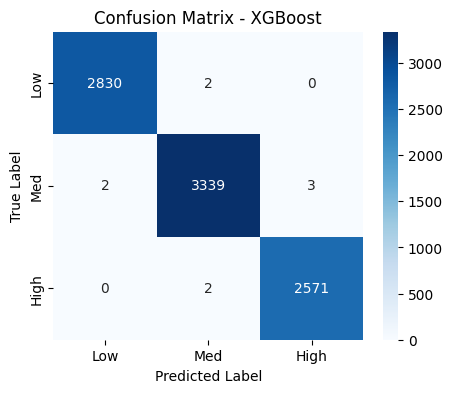


MLP Neural Network
Saved processed dataset for MLP Neural Network → mlp_neural_network_df.csv

Best Hyperparameters:
{'clf__activation': 'relu', 'clf__hidden_layer_sizes': (50,)}

Train Accuracy : 0.9982
Test Accuracy  : 0.9962

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      0.99      1.00      3344
           2       0.99      1.00      1.00      2573

    accuracy                           1.00      8749
   macro avg       1.00      1.00      1.00      8749
weighted avg       1.00      1.00      1.00      8749



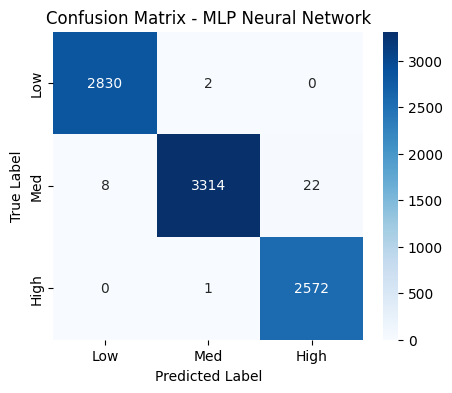

In [ ]:
results = {}
for name, model in models.items():
    print(f"\n{name}")
    print("=" * 60)

    #data transformation
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

    if name in ["Support Vector Machine", "K-Nearest Neighbors", "MLP Neural Network", "Logistic Regression"]:
        # Scaling required
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", StandardScaler(), numeric_cols)
            ],
            remainder="drop"
        )
        model_df = X_train[numeric_cols].copy()

    elif name in ["XGBoost"]:
        # only numeric but no scaling needed
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", "passthrough", numeric_cols)
            ],
            remainder="drop"
        )
        model_df = X_train[numeric_cols].copy()

    else:
        # DecisionTree, RandomForest - raw df
        preprocessor = "passthrough"
        model_df = X_train.copy()

    file_name = f"{name.replace(' ', '_').lower()}_df.csv"
    joblib.dump(model_df, file_name)
    print(f"Saved processed dataset for {name} → {file_name}")


    pipe = Pipeline([
        ("pre", preprocessor),
        ("clf", model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=3,
        scoring="accuracy",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    print("\nBest Hyperparameters:")
    print(grid.best_params_)

    best_model = grid.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_acc  = accuracy_score(y_train, y_train_pred)
    test_acc   = accuracy_score(y_test,  y_test_pred)

    train_prec = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_prec  = precision_score(y_test,  y_test_pred, average='weighted', zero_division=0)

    train_rec  = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_rec   = recall_score(y_test,  y_test_pred, average='weighted', zero_division=0)

    train_f1   = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_f1    = f1_score(y_test,  y_test_pred, average='weighted', zero_division=0)

    results[name] = {
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Train Precision": train_prec,
        "Test Precision": test_prec,
        "Train Recall": train_rec,
        "Test Recall": test_rec,
        "Train F1": train_f1,
        "Test F1": test_f1
    }

    print(f"\nTrain Accuracy : {train_acc:.4f}")
    print(f"Test Accuracy  : {test_acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Low", "Med", "High"],
                yticklabels=["Low", "Med", "High"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("=" * 60)


In [ ]:
hp_classification_results_df = pd.DataFrame(results).T
hp_classification_results_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1
Logistic Regression,0.997857,0.998286,0.997864,0.998291,0.997857,0.998286,0.997857,0.998286
Decision Tree,1.000000,0.999314,1.000000,0.999314,1.000000,0.999314,1.000000,0.999314
Random Forest,1.000000,0.999657,1.000000,0.999657,1.000000,0.999657,1.000000,0.999657
Support Vector Machine,0.997600,0.992228,0.997600,0.992242,0.997600,0.992228,0.997599,0.992225
K-Nearest Neighbors,1.000000,0.929363,1.000000,0.929288,1.000000,0.929363,1.000000,0.929280
XGBoost,1.000000,0.998971,1.000000,0.998971,1.000000,0.998971,1.000000,0.998971
MLP Neural Network,0.998200,0.996228,0.998208,0.996248,0.998200,0.996228,0.998200,0.996226


**Best Performing Model**

The best-performing models are Decision Tree, Random Forest, and XGBoost, each achieving extremely high accuracy, precision, recall, and F1 on both training and testing sets. Their test accuracies above 99.8% indicate that these models generalize exceptionally well to unseen data. XGBoost in particular provides the most stable performance without meaningful drops between train and test scores. These models are the most reliable for this classification task based on your evaluation metrics.

**Least Performing Model**

The weakest performer in your results is the K-Nearest Neighbors (KNN) classifier, which shows a test accuracy of only 92.9%, significantly below the others. While it achieves perfect accuracy on the training set, it struggles to generalize to unseen data. In comparison, SVM performs better but still falls short of the leading models.


**Overfitting/Underfitting Behaviour**

KNN shows clear overfitting, as it memorizes the training data perfectly (100% accuracy) but experiences a large performance drop on the test set. The Support Vector Machine shows a mild generalization gap, meaning it is not severely overfitting but performs slightly weaker on new data. The tree-based models—Decision Tree, Random Forest, and XGBoost—show extremely small gaps between training and test scores, indicating excellent generalization with no signs of underfitting or overfitting. Logistic Regression and MLP also show stable behavior, with nearly identical performance on train and test splits.


# Regression

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43742 entries, 0 to 43741
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age_group                     43742 non-null  int64  
 1   Sex                           43742 non-null  int64  
 2   Topic                         43742 non-null  int64  
 3   Data_source                   43742 non-null  int64  
 4   Health_condition-Data_source  43742 non-null  int64  
 5   Period                        43742 non-null  int64  
 6   Year                          43742 non-null  int64  
 7   Denominator                   43742 non-null  float64
 8   Denominator_is                43742 non-null  int64  
 9   Number_with_outcome           43742 non-null  float64
 10  Numerator_is                  43742 non-null  int64  
 11  Rate_95CI                     43742 non-null  int64  
 12  Rate_SF_pop                   43742 non-null  float64
 13  C

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/labelled data.csv")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df['Label'] = df['Label'].replace({
    "Low Risk": 0,
    "Medium Risk": 1,
    "High Risk": 2
})

X = df.drop(columns=['Rate_SF_pop'])
y = df['Rate_SF_pop']

/tmp/ipython-input-2239940797.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace({


In [ ]:
X

,Age_group,Sex,Topic,Data_source,Health_condition-Data_source,Period,Year,Denominator,Denominator_is,Number_with_outcome,...,Rate_title,Trend_title,Filter_1000_or_more,Sort_1000_or_more,Primary_Neighborhood,Cause of death rank,Death_tooltip,Latest_data,Unique_row_id,Label
0,0,0,5,0,32,43,22,-0.198251,18,-0.704734,...,1099,210,3,-0.912877,1,0,1,0,-1.283738,0
1,0,0,5,0,32,47,23,-0.227846,18,-0.510436,...,1100,210,3,-0.912877,1,0,1,0,-0.354644,0
2,0,0,5,0,32,50,24,-0.261700,18,-0.478053,...,1102,210,3,-0.912877,1,0,1,0,-0.253600,0
3,0,0,5,0,32,52,25,-0.287534,18,-0.715529,...,1103,210,3,-0.912877,1,0,1,0,-1.358848,0
4,0,0,5,0,32,27,22,-0.314219,18,-0.747912,...,1097,210,3,-0.912877,1,0,1,0,-1.621209,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43737,43,2,5,11,384,39,22,2.085356,12,0.936005,...,6603,1228,1,1.418047,1,0,1,0,1.274209,0
43738,43,2,5,11,384,48,22,-0.606200,12,-0.715529,...,6607,1228,3,-0.912877,1,0,1,0,-1.295162,0
43739,43,2,5,11,384,48,22,-0.563687,12,-0.553614,...,6607,1228,3,-0.912877,1,0,1,0,-0.472693,0
43740,43,2,5,11,384,48,22,0.283652,12,-0.348521,...,6607,1228,4,0.252585,1,0,1,0,0.099497,0



Linear Regression


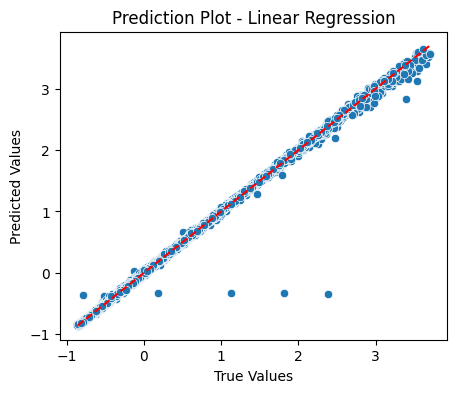


Ridge Regression


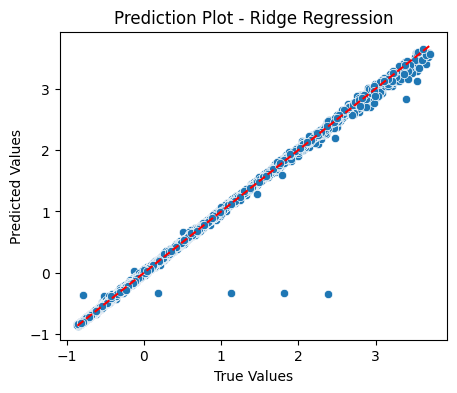


Lasso Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.999e+01, tolerance: 3.504e+00
  model = cd_fast.enet_coordinate_descent(


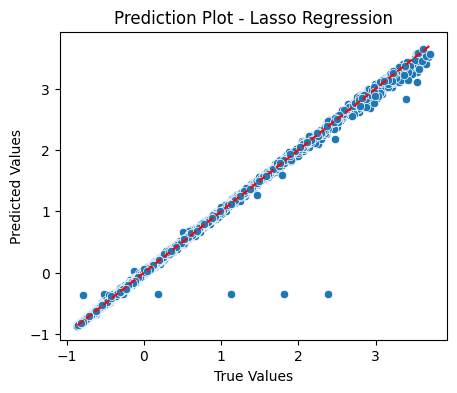


Decision Tree


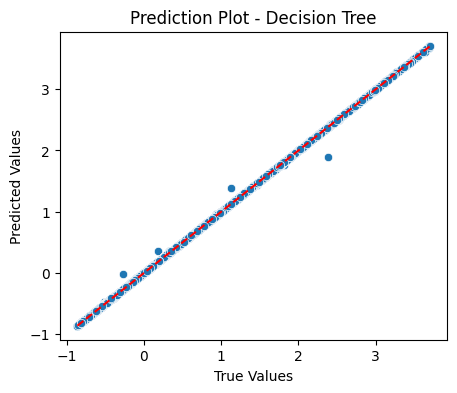


Random Forest


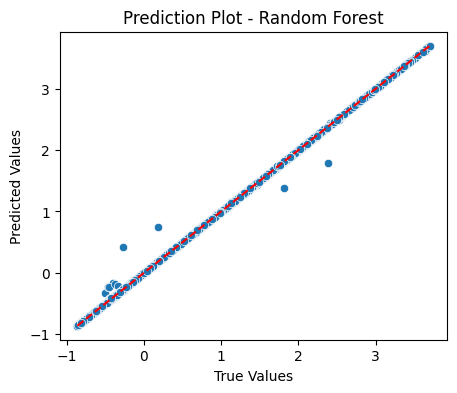


Support Vector Regressor


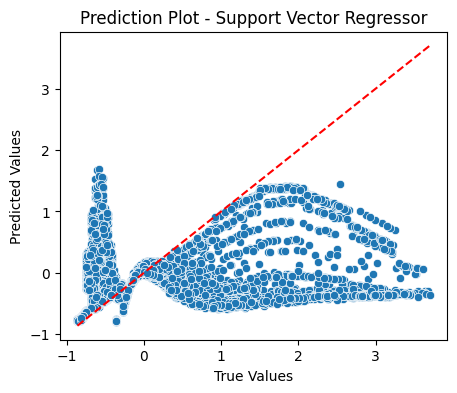


K-Nearest Neighbors


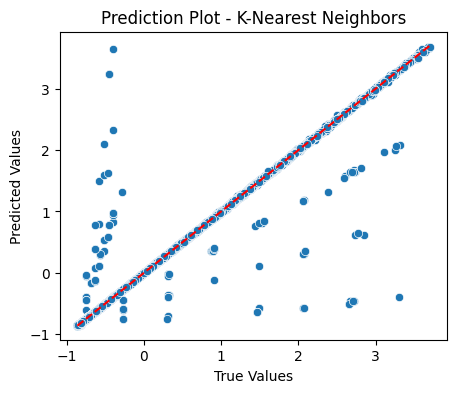


XGBoost Regressor


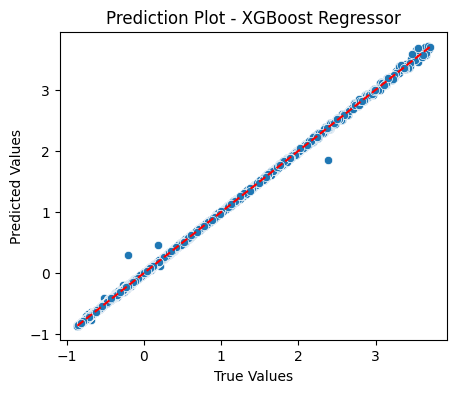


MLP Neural Network


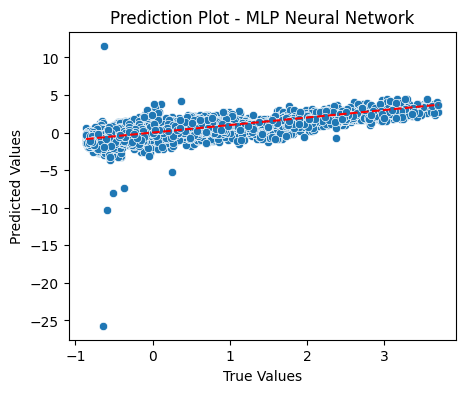

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "Decision Tree": DecisionTreeRegressor(random_state=14),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=14),
    "Support Vector Regressor": SVR(kernel='rbf'),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=3),
    "XGBoost Regressor": xgb.XGBRegressor(objective='reg:squarederror', random_state=14),
    "MLP Neural Network": MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=300,
        random_state=14
    )
}


results = {}


for name, model in models.items():
    print(f"\n{name}")
    print("=" * 60)

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # Metrics
    train_mae  = mean_absolute_error(y_train, y_train_pred)
    test_mae   = mean_absolute_error(y_test, y_test_pred)

    train_mse  = mean_squared_error(y_train, y_train_pred)
    test_mse   = mean_squared_error(y_test, y_test_pred)

    train_rmse = np.sqrt(train_mse)
    test_rmse  = np.sqrt(test_mse)

    train_r2   = r2_score(y_train, y_train_pred)
    test_r2    = r2_score(y_test, y_test_pred)

    results[name] = {
        "Train MAE": train_mae,
        "Test MAE": test_mae,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Train R2": train_r2,
        "Test R2": test_r2
    }

    plt.figure(figsize=(5,4))
    sns.scatterplot(x=y_test, y=y_test_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Prediction Plot - {name}")
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], 'r--')
    plt.show()

    print("=" * 60)

In [ ]:
regression_results_df = pd.DataFrame(results).T
regression_results_df

,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2
Linear Regression,1.161428e-02,0.011992,3.845356e-02,0.046160,0.998523,0.997858
Ridge Regression,1.161139e-02,0.011989,3.845356e-02,0.046160,0.998523,0.997858
Lasso Regression,1.112922e-02,0.011468,3.884147e-02,0.046651,0.998493,0.997812
Decision Tree,8.131560e-16,0.000302,1.590778e-15,0.006923,1.000000,0.999952
Random Forest,1.762539e-04,0.000572,6.488492e-03,0.013429,0.999958,0.999819
Support Vector Regressor,5.710437e-01,0.565138,9.568790e-01,0.952034,0.085580,0.088773
K-Nearest Neighbors,1.053328e-02,0.019898,1.086070e-01,0.180148,0.988220,0.967373
XGBoost Regressor,4.001632e-03,0.005415,6.291410e-03,0.012805,0.999960,0.999835
MLP Neural Network,5.714130e-01,0.567709,9.388584e-01,0.795696,0.119698,0.363474


**Best Fitting Models**

The Decision Tree, Random Forest, and XGBoost models show extremely strong performance, with near-zero errors and R² scores above 0.999, indicating almost perfect predictive ability on both train and test sets. Random Forest and XGBoost generalize particularly well, showing very low Test MAE/RMSE, meaning the model's predictions are highly accurate even on unseen data. Decision Tree also performs well, though its near-zero training error hints at slight overfitting, but test performance remains excellent. These three models clearly capture the underlying patterns with minimal noise.

**Moderately Well-Fitting Models**

Linear Regression, Ridge, and Lasso show strong overall performance, with high R² values around 0.997–0.998 and low MAE/RMSE on both training and testing sets. These models suggest that the relationship between predictors and the target is mostly linear. Lasso slightly improves generalization compared to the others by reducing Test MAE, implying mild noise reduction through feature regularization. K-Nearest Neighbors also performs reasonably well but shows a notable gap between train and test RMSE.

**Poorly Fitting Models**

Support Vector Regressor (SVR) and the MLP Neural Network perform significantly worse, with very high MAE/RMSE and low R² values (as low as ~0.08 to 0.36). These models fail to capture the structure of the data. SVR in particular struggles to model complex relationships and the MLP model also performs poorly, likely because neural networks require optimized architectures.

### Hyperparameter Tuning


Linear Regression

Best Hyperparameters:
{}
Saved transformed file → reg_linear_regression_data.csv


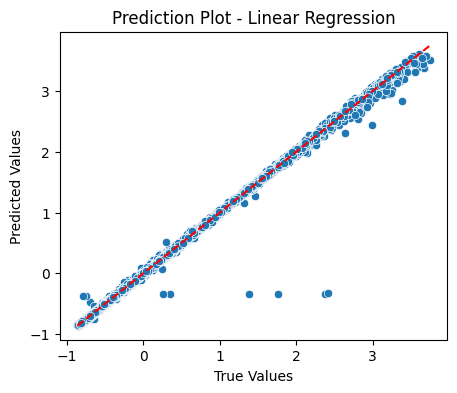


Ridge Regression

Best Hyperparameters:
{'reg__alpha': 1}
Saved transformed file → reg_ridge_regression_data.csv


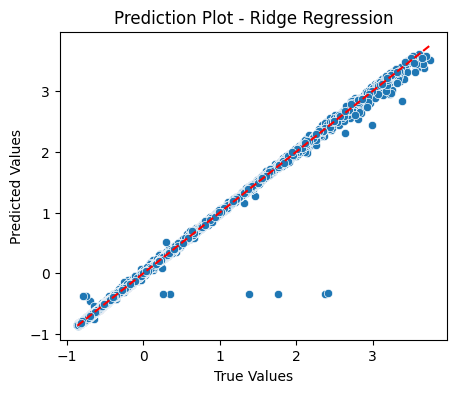


Lasso Regression

Best Hyperparameters:
{'reg__alpha': 0.0001}
Saved transformed file → reg_lasso_regression_data.csv


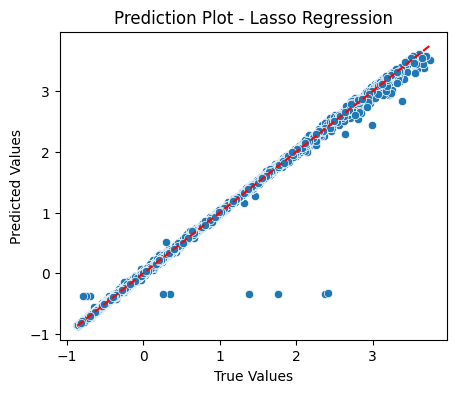


Decision Tree

Best Hyperparameters:
{'reg__max_depth': None, 'reg__max_leaf_nodes': None, 'reg__min_samples_leaf': 1, 'reg__min_samples_split': 2}
Saved transformed file → reg_decision_tree_data.csv


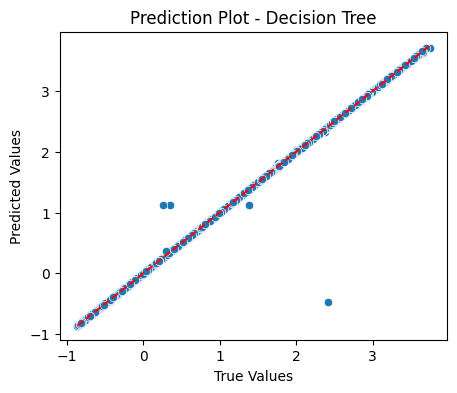


Random Forest

Best Hyperparameters:
{'reg__max_depth': None, 'reg__n_estimators': 300}
Saved transformed file → reg_random_forest_data.csv


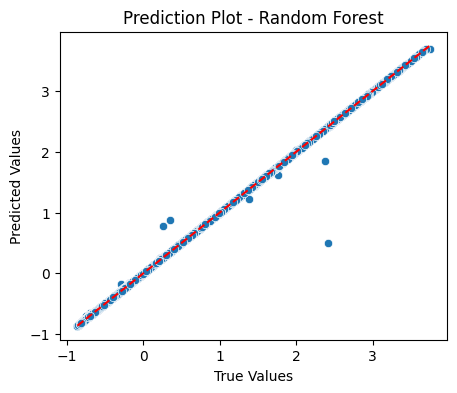


Support Vector Regressor

Best Hyperparameters:
{'reg__C': 10}
Saved transformed file → reg_support_vector_regressor_data.csv


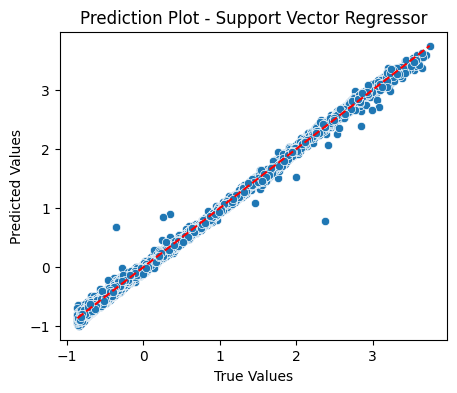


K-Nearest Neighbors

Best Hyperparameters:
{'reg__n_neighbors': 5, 'reg__weights': 'distance'}
Saved transformed file → reg_k-nearest_neighbors_data.csv


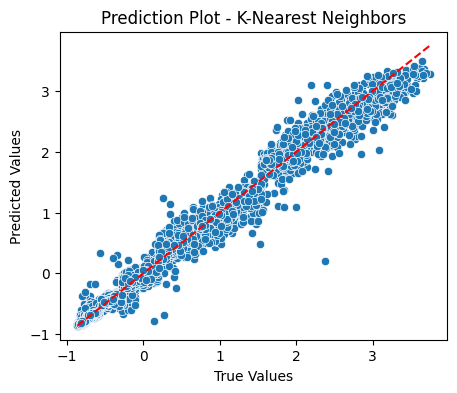


XGBoost Regressor

Best Hyperparameters:
{'reg__learning_rate': 0.1, 'reg__max_depth': 5, 'reg__n_estimators': 300}
Saved transformed file → reg_xgboost_regressor_data.csv


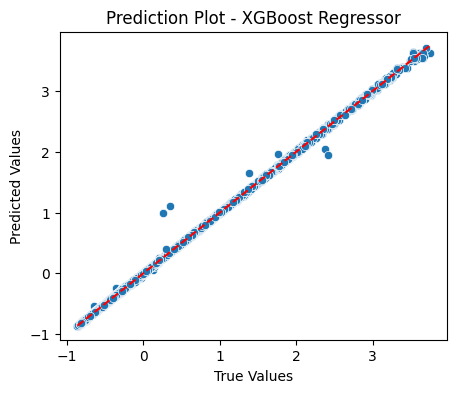


MLP Neural Network

Best Hyperparameters:
{'reg__activation': 'tanh', 'reg__hidden_layer_sizes': (100, 50)}
Saved transformed file → reg_mlp_neural_network_data.csv


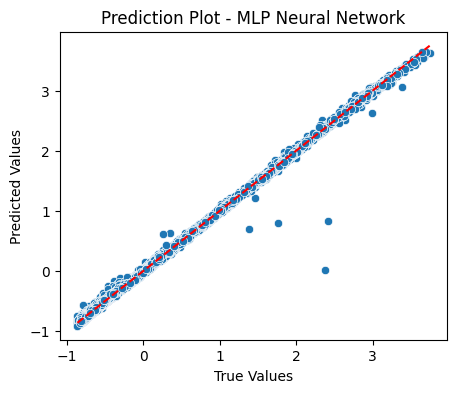

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns


X = df.drop(columns=["Rate_SF_pop"])
y = df["Rate_SF_pop"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=67
)


models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=14),
    "Random Forest": RandomForestRegressor(random_state=14),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "XGBoost Regressor": xgb.XGBRegressor(objective="reg:squarederror", random_state=14),
    "MLP Neural Network": MLPRegressor(random_state=14)
}


param_grids = {
    "Linear Regression": {},

    "Ridge Regression": {
        "reg__alpha": [0.1, 1, 10]
    },

    "Lasso Regression": {
        "reg__alpha": [0.0001, 0.001, 0.01]
    },

    "Decision Tree": {
        "reg__max_depth": [3, 5, 10, None],
        "reg__min_samples_split": [2, 5, 10],
        "reg__min_samples_leaf": [1, 2, 4],
        "reg__max_leaf_nodes": [None, 10, 20, 50]
    },

    "Random Forest": {
        "reg__n_estimators": [100, 200, 300],
        "reg__max_depth": [5, 10, 20, None],

    },

    "Support Vector Regressor": {
        "reg__C": [0.1, 1, 10],

    },

    "K-Nearest Neighbors": {
        "reg__n_neighbors": [3, 5, 7, 9],
        "reg__weights": ["uniform", "distance"]
    },

    "XGBoost Regressor": {
        "reg__n_estimators": [200, 300],
        "reg__max_depth": [3, 5, 7],
        "reg__learning_rate": [0.01, 0.05, 0.1],
    },

    "MLP Neural Network": {
        "reg__hidden_layer_sizes": [(100,), (100, 50)],
        "reg__activation": ["relu", "tanh"]
    }
}


num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="passthrough"
)


results = {}

for name, model in models.items():
    print(f"\n{name}")
    print("=" * 60)

    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("reg", model)
    ])

    grid = GridSearchCV(pipe, param_grids.get(name, {}), cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_

    print("\nBest Hyperparameters:")
    print(grid.best_params_)

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae  = mean_absolute_error(y_test, y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2  = r2_score(y_test, y_test_pred)

    results[name] = {
        "Train MAE": train_mae,
        "Test MAE": test_mae,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Train R2": train_r2,
        "Test R2": test_r2
    }


    reg_df = pd.DataFrame(
    np.asarray(best_model.named_steps["preprocess"].transform(X))
    )

    file_name = f"reg_{name.replace(' ', '_').lower()}_data.csv"
    reg_df.to_csv(file_name, index=False)
    print(f"Saved transformed file → {file_name}")

    plt.figure(figsize=(5,4))
    sns.scatterplot(x=y_test, y=y_test_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Prediction Plot - {name}")
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], "r--")
    plt.show()

    print("=" * 60)


In [62]:
hp_regression_results_df = pd.DataFrame(results).T
hp_regression_results_df

,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2
Linear Regression,1.140849e-02,0.012386,3.481878e-02,0.056538,0.998791,0.996770
Ridge Regression,1.140391e-02,0.012381,3.481892e-02,0.056539,0.998791,0.996770
Lasso Regression,1.127367e-02,0.012264,3.490524e-02,0.056653,0.998785,0.996757
Decision Tree,8.668986e-16,0.000702,1.675619e-15,0.033381,1.000000,0.998874
Random Forest,1.650667e-04,0.000637,5.889831e-03,0.022828,0.999965,0.999473
Support Vector Regressor,4.040661e-02,0.041498,4.962293e-02,0.056819,0.997544,0.996738
K-Nearest Neighbors,5.641537e-09,0.072449,2.065740e-08,0.123850,1.000000,0.984500
XGBoost Regressor,4.266713e-03,0.005208,7.082863e-03,0.016201,0.999950,0.999735
MLP Neural Network,1.857560e-02,0.019653,3.143754e-02,0.042777,0.999014,0.998151


**Best Performing Model**

The strongest performers in your regression results are XGBoost Regressor and Random Forest, both showing extremely low MAE/RMSE and very high test R² values (0.9997 and 0.9995). These models capture nearly all variance in the data while maintaining excellent generalization to the test set. Decision Tree also performs strongly with a test R² of ~0.9989, but slightly behind the ensemble models. Overall, tree-based ensemble methods dominate, offering the most stable and accurate predictions.

**Least Performing Model**

The K-Nearest Neighbors Regressor exhibits the weakest test performance, with a high test MAE (0.072) and RMSE (0.124) and the lowest test R² (0.9845). Although KNN achieves a perfect score on the training set, its generalization drastically drops, showing poor predictive capability on unseen data. Support Vector Regressor also underperforms relative to the top models, with noticeably higher errors and a lower R². These models struggle to fit the underlying structure of your dataset compared to tree-based methods.

**Overfitting/Underfitting Behaviour**

KNN shows severe overfitting, with perfect training error but a significant drop in test performance. The Decision Tree also shows mild overfitting: it has perfect training metrics but slightly weaker performance on the test set, though still strong. In contrast, Random Forest and XGBoost demonstrate excellent generalization, with small gaps between training and test errors—classic signs of well-regularized ensemble models. Linear/Ridge/Lasso regressions exhibit a consistent and moderate train-test gap, indicating stable but less expressive fits without clear overfitting.